In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.7, 1.3), shear=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.7, 1.3), shear=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
image_datasets = {x: datasets.ImageFolder(os.path.join('data', x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32 if x == 'train' else 2, shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

In [4]:
num_samples = float(sum([len(s) for s in image_datasets.values()]))
num_classes = len(image_datasets['train'].classes)
class_weights = [num_samples / (num_classes * len(image_datasets['train'].samples[i])) for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [24]:
model_ft = models.resnet50(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

In [27]:
weight_for_class_normal = 5291 / (1341 * 2)
weight_for_class_pneumonia = 5291 / (3875 * 2)

class_weights_tensor = torch.tensor([weight_for_class_normal, weight_for_class_pneumonia], dtype=torch.float32)
class_weights_tensor = class_weights_tensor.to(device)


# weighted loss function using to ensure that the model gives prority to the normal samples as well
#although they are much lesser in quantity
weighted_loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [28]:

optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.0001)
exp_lr_scheduler = ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.1, patience=5)

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    # Initialize arrays to store epoch metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'val':
                scheduler.step(running_loss)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [30]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model_ft, weighted_loss_function, optimizer_ft, exp_lr_scheduler, num_epochs=20)


Epoch 1/20
----------
train Loss: 0.5065 Acc: 0.7790
val Loss: 0.5544 Acc: 0.6250
Epoch 2/20
----------
train Loss: 0.3720 Acc: 0.8432
val Loss: 0.5510 Acc: 0.6250
Epoch 3/20
----------
train Loss: 0.3449 Acc: 0.8509
val Loss: 0.5545 Acc: 0.6875
Epoch 4/20
----------
train Loss: 0.3235 Acc: 0.8612
val Loss: 0.5512 Acc: 0.6875
Epoch 5/20
----------
train Loss: 0.3166 Acc: 0.8643
val Loss: 0.3890 Acc: 0.6875
Epoch 6/20
----------
train Loss: 0.3095 Acc: 0.8670
val Loss: 0.4132 Acc: 0.6875
Epoch 7/20
----------
train Loss: 0.3024 Acc: 0.8666
val Loss: 0.4263 Acc: 0.8125
Epoch 8/20
----------
train Loss: 0.2830 Acc: 0.8854
val Loss: 0.4723 Acc: 0.6875
Epoch 9/20
----------
train Loss: 0.2934 Acc: 0.8743
val Loss: 0.4581 Acc: 0.6875
Epoch 10/20
----------
train Loss: 0.2775 Acc: 0.8835
val Loss: 0.4894 Acc: 0.7500
Epoch 11/20
----------
train Loss: 0.2827 Acc: 0.8804
val Loss: 0.3911 Acc: 0.7500
Epoch 12/20
----------
train Loss: 0.2791 Acc: 0.8906
val Loss: 0.4598 Acc: 0.7500
Epoch 13/20
-

In [20]:
!pip install matplotlib scikit-learn 

  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.4.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.4.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Using cached joblib-1.4.0-py3-none-any.whl (301 kB)
Using cached scipy-1.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached threadpoolctl-3.4.0-py3-none-any.whl (17 kB)


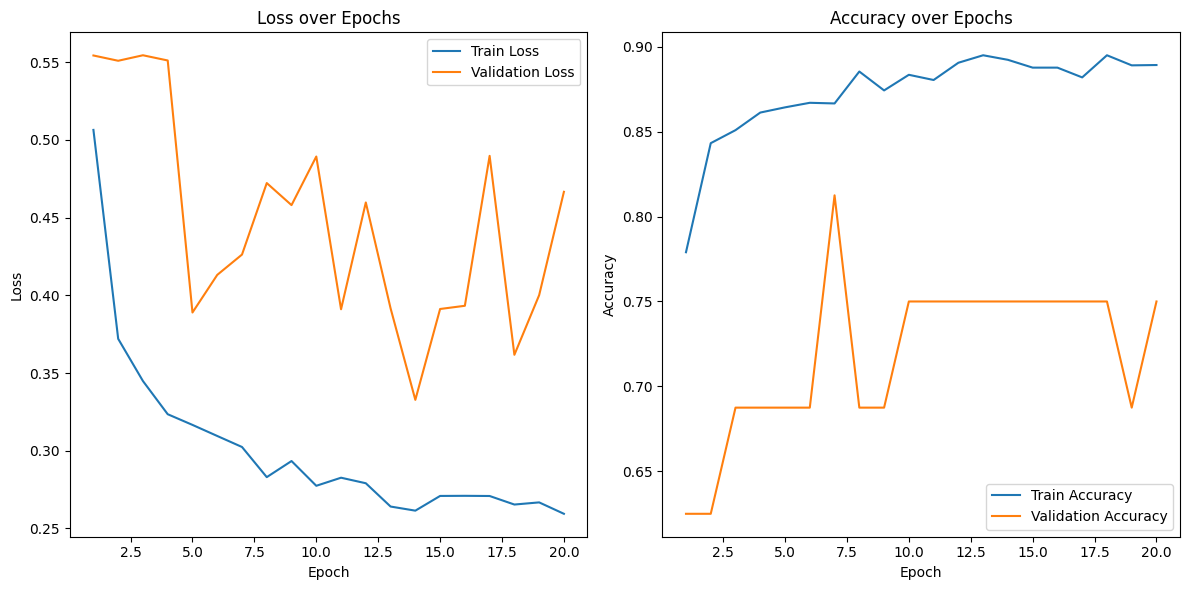

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), train_losses, label='Train Loss')
plt.plot(range(1, 21), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 21), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
from sklearn.metrics import precision_score, f1_score, accuracy_score
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='binary')
    f1 = f1_score(true_labels, predictions, average='binary')
    
    return accuracy, precision, f1

In [42]:
accuracy, precision, f1 = evaluate_model(model_ft, dataloaders['test']) 
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

Test Accuracy: 0.9013
Precision: 0.8979
F1 Score: 0.9045
